<a href="https://colab.research.google.com/github/dcpatton/NLP/blob/master/Friends_Albert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TODO**:

*   Better text augmentation
*   Add speaker as input2
*   Add the annotation as an output target
*   Ensemble model with more diverse models
*   Use 2019 dataset


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import random

print(tf.__version__)

seed = 52

tf.random.set_seed(seed)
random.seed(seed)

2.3.0


# Load and prep data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving friends_test.json to friends_test.json
Saving friends_dev.json to friends_dev.json
Saving friends_train.json to friends_train.json


# Albert

In [3]:
!pip install sentencepiece -q

In [4]:
!wget -nv https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

2020-08-07 17:40:02 URL:https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py [16775/16775] -> "tokenization.py" [1]


In [5]:
from numpy import array

def albert_encode(texts):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
      text = tokenizer.tokenize(text)
      text = text[:max_seq_length-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      input_sequence = text
      pad_len = max_seq_length - len(input_sequence)
      tokens = tokenizer.convert_tokens_to_ids(input_sequence)
      tokens += [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_seq_length
      all_tokens.append(tokens)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)

    return [array(all_tokens), array(all_masks), array(all_segments)]

In [6]:
def prep_data(df):
    
    texts = []
    labels = []

    for _,row in df.iterrows():
      texts.append(row.utterance)
      labels.append(row.label)

    return albert_encode(texts), array(labels)

# Competition prediction task



> In the competition they only predict samples with joy, sadness, anger, and neutral. All others are discarded. 



In [7]:
import pandas as pd

allowed_emotions = ['joy', 'sadness', 'anger', 'neutral']

df = pd.read_json('friends_train.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(utterance)
      # utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

train_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 

df = pd.read_json('friends_dev.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(utterance)
      # utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

val_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion'])

df = pd.read_json('friends_test.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(utterance)
      # utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

test_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion'])
test_df['emotion'].value_counts()

neutral    1287
joy         304
anger       161
sadness      85
Name: emotion, dtype: int64

Reduce the number of neutral samples:

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
# lets combine + shuffle train and val and then split again.
combined_df = pd.concat([train_df, val_df])
combined_df = combined_df.sample(frac=1).reset_index(False)
# indices = []
# for idx, row in combined_df.iterrows():
#   if row.emotion == 'neutral':
#     indices.append(idx)

# n = 5243-1400
# combined_df.drop(indices[:n], axis='index', inplace=True)
# train_df, val_df = train_test_split(combined_df, test_size=0.2, shuffle=True, 
#                                     stratify=combined_df['emotion'], random_state=seed)
# print(train_df['emotion'].value_counts())

# Text augmentation

In [9]:
!pip install nlpaug -q
import nlpaug.augmenter.word as naw

In [10]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [11]:
text = train_df.head(1)['utterance'].values[0]
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)
augmented_text2 = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)
print(augmented_text2)

Original:
also I was the point person on my company`s transition from the KL-5 to GR-6 system.
Augmented Text:
also Ace was the point person on my troupe ` s transition from the KL - 5 to GR - 6 scheme .
also I follow the point individual on my company ` s transition from the KL - five to GR - sextuplet system .


In [12]:
aug = naw.SynonymAug(aug_src='wordnet')
utterances = []
emotions = []
for _,row in train_df.iterrows():
    utterances.append(row.utterance)
    emotions.append(row.emotion)
    if row.emotion == 'sadness' or row.emotion == 'anger':  # add one augmented sample for anger
      augmented = aug.augment(utterance)
      utterances.append(augmented)
      emotions.append(row.emotion)
    if row.emotion == 'sadness':  # add two for sadness
      augmented = aug.augment(utterance)
      utterances.append(augmented)
      emotions.append(row.emotion)

train_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 

In [13]:
max_len = -1
for _,row in combined_df.iterrows():
  length = len(row.utterance)
  if length > max_len:
    max_len = length

max_len

241

In [14]:
# create the labels as integers
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['emotion'].values)
train_df.drop(['emotion'], axis='columns', inplace=True)

val_df['label'] = labelEncoder.transform(val_df['emotion'].values)
val_df.drop(['emotion'], axis='columns', inplace=True)

test_df['label'] = labelEncoder.transform(test_df['emotion'].values)
test_df.drop(['emotion'], axis='columns', inplace=True)

num_classes=len(labelEncoder.classes_)
labelEncoder.classes_

array(['anger', 'joy', 'neutral', 'sadness'], dtype=object)

# Model

In [15]:
max_seq_length = 128

In [16]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model


def get_model(albert_trainable=False, num_hidden=8):

  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")
  albert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/1",
                                trainable=albert_trainable)
  pooled_output, sequence_output = albert_layer([input_word_ids, input_mask, segment_ids])

  m = Dense(num_hidden, activation='relu')(pooled_output)
  out = Dense(num_classes, activation='softmax')(m)

  return Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[out])


model1 = get_model(albert_trainable=False, num_hidden=8)
model2 = get_model(albert_trainable=False, num_hidden=16)
model3 = get_model(albert_trainable=False, num_hidden=32)

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")

y1 = model1([input_word_ids, input_mask, segment_ids])
y2 = model2([input_word_ids, input_mask, segment_ids])
y3 = model3([input_word_ids, input_mask, segment_ids])

outputs = tf.keras.layers.average([y1, y2, y3])
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=outputs)  # Ensemble model

model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 4)            11689772    input_word_ids[0][0]             
                                                                 input_mask[0][0]      

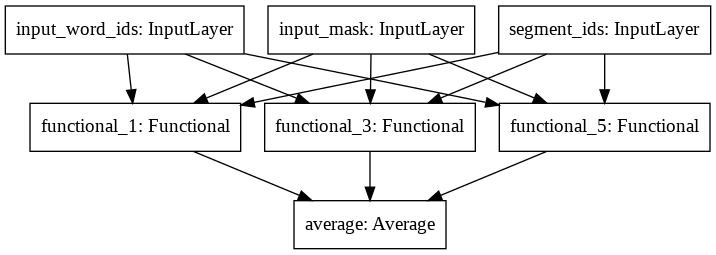

In [17]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=False)

In [18]:
import tokenization
import sentencepiece

albert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/1",
                                trainable=False)

sp_model_file = albert_layer.resolved_object.sp_model_file.asset_path.numpy()
tokenizer = tokenization.FullSentencePieceTokenizer(sp_model_file)

In [19]:
x_train, y_train = prep_data(train_df)
x_val, y_val = prep_data(val_df)
x_test, y_test = prep_data(test_df)

y_true = y_test

y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [20]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(num_classes, average='micro', name='f1')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=[f1_score])

In [21]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    print('Using learning_rate = ' + str(self.model.optimizer.learning_rate.numpy()))

# Train

In [22]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint( filepath, monitor='val_loss', verbose=0, 
                                        save_best_only=True, save_weights_only=True, 
                                        mode='auto')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                      verbose=1, mode='auto', restore_best_weights=False)

history = model.fit(x_train, y_train, epochs=100, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es],
                    )

Epoch 1/100
254/254 [==============================] - 128s 505ms/step - loss: 0.9511 - f1: 0.6473 - val_loss: 0.9984 - val_f1: 0.6426
Epoch 2/100
254/254 [==============================] - 127s 498ms/step - loss: 0.8527 - f1: 0.6756 - val_loss: 0.9973 - val_f1: 0.6597
Epoch 3/100
254/254 [==============================] - 127s 498ms/step - loss: 0.8268 - f1: 0.6851 - val_loss: 0.9685 - val_f1: 0.6649
Epoch 4/100
254/254 [==============================] - 127s 498ms/step - loss: 0.8120 - f1: 0.6888 - val_loss: 0.9595 - val_f1: 0.6623
Epoch 5/100
254/254 [==============================] - 126s 498ms/step - loss: 0.8023 - f1: 0.6899 - val_loss: 0.9554 - val_f1: 0.6413
Epoch 6/100
254/254 [==============================] - 126s 497ms/step - loss: 0.7879 - f1: 0.6941 - val_loss: 0.9578 - val_f1: 0.6544
Epoch 7/100
254/254 [==============================] - 126s 497ms/step - loss: 0.7793 - f1: 0.6989 - val_loss: 1.0037 - val_f1: 0.6478
Epoch 8/100
254/254 [==============================] - 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


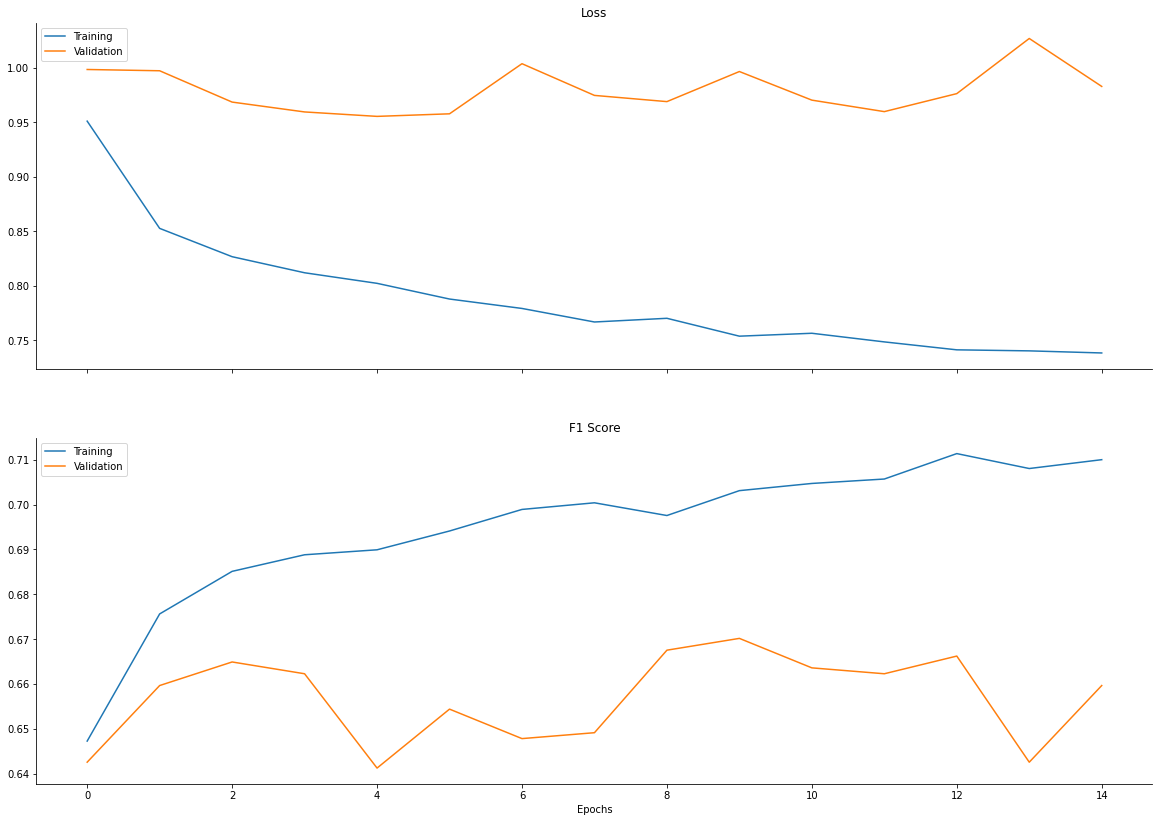

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Fine tune

In [24]:
model.load_weights(filepath)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 4)            11689772    input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [25]:
model1_layer = model.get_layer(index=3)
model1_layer.get_layer(index=3).trainable=True

model2_layer = model.get_layer(index=4)
model2_layer.get_layer(index=3).trainable=True

model3_layer = model.get_layer(index=5)
model3_layer.get_layer(index=3).trainable=True


model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 4)            11689772    input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), 
              loss='categorical_crossentropy', 
              metrics=[f1_score])

In [28]:
history = model.fit(x_train, y_train, epochs=100, verbose=1, batch_size=8,
                    validation_data=(x_val, y_val), callbacks=[mc, es],
                    )

Epoch 1/100
1015/1015 [==============================] - 400s 394ms/step - loss: 0.7697 - f1: 0.7130 - val_loss: 0.8773 - val_f1: 0.7043
Epoch 2/100
1015/1015 [==============================] - 398s 392ms/step - loss: 0.7024 - f1: 0.7324 - val_loss: 0.8423 - val_f1: 0.7148
Epoch 3/100
1015/1015 [==============================] - 398s 392ms/step - loss: 0.6630 - f1: 0.7434 - val_loss: 0.8456 - val_f1: 0.7201
Epoch 4/100
1015/1015 [==============================] - 398s 392ms/step - loss: 0.6369 - f1: 0.7466 - val_loss: 0.8365 - val_f1: 0.7280
Epoch 5/100
1015/1015 [==============================] - 398s 392ms/step - loss: 0.6060 - f1: 0.7538 - val_loss: 0.8127 - val_f1: 0.7201
Epoch 6/100
1015/1015 [==============================] - 398s 392ms/step - loss: 0.5796 - f1: 0.7559 - val_loss: 0.8694 - val_f1: 0.7214
Epoch 7/100
1015/1015 [==============================] - 397s 391ms/step - loss: 0.5526 - f1: 0.7637 - val_loss: 0.8481 - val_f1: 0.7148
Epoch 8/100
1015/1015 [==================

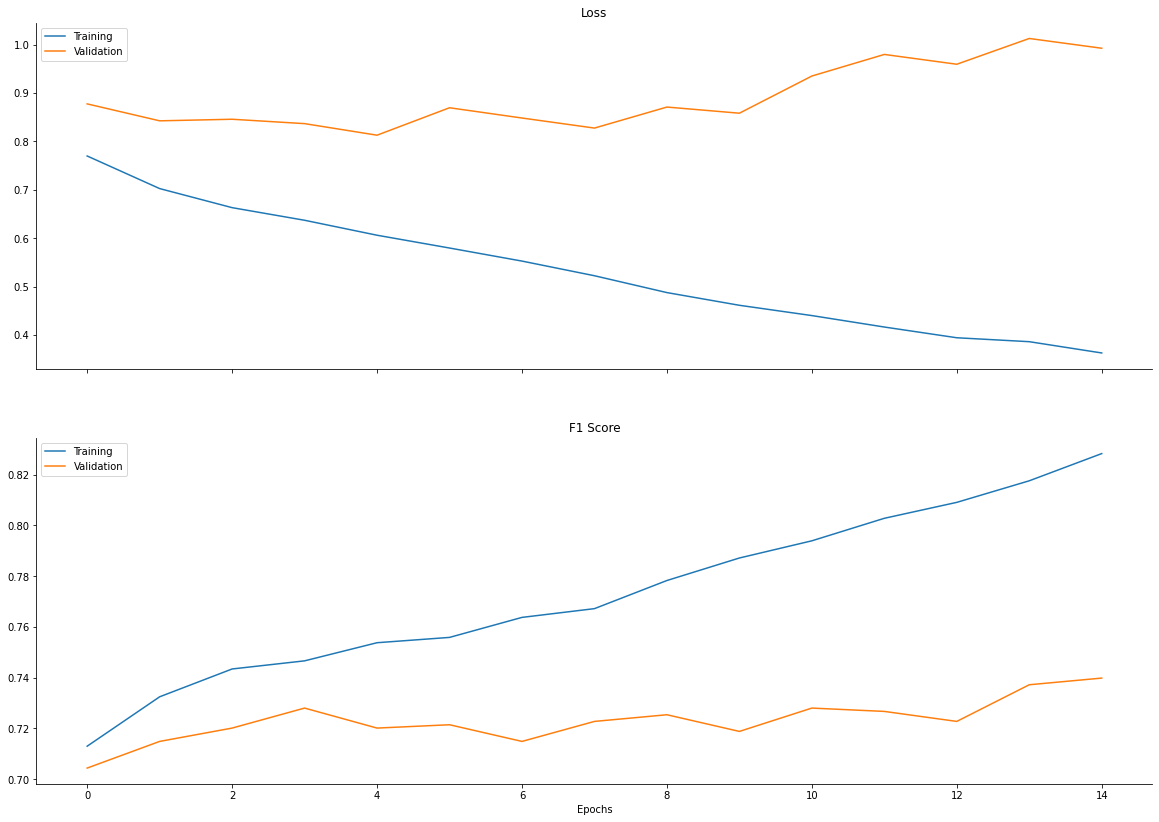

In [29]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [30]:
model.load_weights(filepath)
model.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 26s 444ms/step - loss: 0.6312 - f1: 0.7790


[0.6312125325202942, 0.778987467288971]

* Adam with fine-tuning                        : loss: 0.1261 - f1: 0.7763
* with original split                          : loss: 0.1281 - f1: 0.7670
* original split with no Dense layer           : loss: 0.6591 - f1: 0.7735
* Adam with original split, no SFCE            : loss: 0.6968 - f1: 0.7703
* with text augmentation                       : loss: 0.6735 - f1: 0.7741
* ensemble model                               : **loss: 0.6312 - f1: 0.7790**


In [31]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)

Check the F1 score for each class

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labelEncoder.classes_))

              precision    recall  f1-score   support

       anger       0.41      0.10      0.16       161
         joy       0.55      0.64      0.60       304
     neutral       0.84      0.95      0.89      1287
     sadness       0.00      0.00      0.00        85

    accuracy                           0.78      1837
   macro avg       0.45      0.42      0.41      1837
weighted avg       0.72      0.78      0.74      1837



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text augmentation helped with anger score.

```
                precision    recall  f1-score   support

       anger       0.48      0.25      0.33       161
         joy       0.56      0.55      0.55       304
     neutral       0.84      0.94      0.89      1287
     sadness       0.00      0.00      0.00        85

    accuracy                           0.77      1837
   macro avg       0.47      0.44      0.44      1837
weighted avg       0.72      0.77      0.74      1837
```



What would the result be if we just predicted neutral for all:

In [33]:
y_pred = np.full(1837, 2)
print(classification_report(y_true, y_pred, target_names=labelEncoder.classes_))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       161
         joy       0.00      0.00      0.00       304
     neutral       0.70      1.00      0.82      1287
     sadness       0.00      0.00      0.00        85

    accuracy                           0.70      1837
   macro avg       0.18      0.25      0.21      1837
weighted avg       0.49      0.70      0.58      1837



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
